# Chapter4. 数据预处理
## 1. 缺失数据处理

In [1]:
# 版本检查
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_v

实际应用中，样本由于各种原因缺少一个或多个值的情况十分常见。

In [8]:
import pandas as pd
# StringIO用来实现类似C语言的字符串读取写入操作
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [9]:
# 返回缺失值位置，行列表示
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

### a. 将缺失值删除
很自然的一个处理缺失值的方法是将存在缺失值的特征或者样本从数据集中删除

In [10]:
# 行删除，删除样本
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [11]:
# 列删除，删除特征
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


dropna方法还支持了其他的参数，以应对各种情况：

In [12]:
# 只删除全是缺失值的行
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [13]:
# 删除所有非Nan值个数少于4的行
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [15]:
# 删除在指定列中出现缺失值的行
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


删除缺失值很方便，但是很可能会丢掉重要的特征，会丢失有价值信息；如果删除了过多的样本，也会导致分析结果的可靠性不高。

### b. 缺失数据的填充
为了避免丢失重要特征或者删除太多的样本，可以使用均值插补的方式，使用相应特征的均值来填补缺失值。在sklearn中可以使用Impute方法来实现。

In [28]:
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

/home/tuser/Software/Anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [29]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

可以看到缺失值被列均值填补

## 2. 处理类别数据
类别数据包括标称特征（衣服颜色）、有序特征（衣服大小XL等可排序）

In [57]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


可以看到，里面包含标称特征(color)，有序特征(Size)，数值特征(Price)。

### a. 有序特征的映射

In [58]:
# 将有序特征按照某种规则映射为整数
size_mapping = {'XL': 3, 
                'L': 2, 
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [59]:
# 逆映射，将整数值还原
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### b. 类标的编码
可以将类标按照类似上述有序特征的方式进行映射

In [60]:
import numpy as np

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [61]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [62]:
# 同样的也可以做逆映射
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


使用sklearn的LabelEncoder方法可以更方便地对类标进行整数编码：

In [63]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [64]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### c. 标称特征上的独热编码

In [65]:
X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

从上面可以看到Numpy数组X的第一列被赋予新的color值。但是，虽然颜色的值没有特定的顺序，但是学习算法还是假定green大于blue、red大于green，这种标称方法，可能在学习过程中产生影响。

解决此问题可以使用独热编码(one-hot encoding)的方式，它将color转换为三个新特征blue、red、green，并使用二进制来标识颜色，例如蓝色：blue = 1, green=0, red = 0; 绿色：blue = 0, green = 1, red = 0

In [70]:
from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(categorical_features=[0])
# 去除警告
ohe = OneHotEncoder(categories='auto')
ohe.fit_transform(X).toarray()

array([[0., 1., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 1.]])

In [71]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


## 3. 将数据集划分为训练集和测试集

In [73]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# 类标；酒精度；苹果酸；灰；灰的碱度；镁；酚总量；黄酮类化合物；非黄烷类酚类；
# 原花青素；颜色强度；色调；OD280 / OD315稀释的葡萄酒；脯氨酸
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class label', np.unique(df_wine['Class label']))
df_wine.head()

Class label [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


葡萄酒样本库含有13个不同的特征，对178个葡萄酒样本的化学特征做出了描述。下面对该数据集进行切分：

In [76]:
# 版本检查，不同版本库的调用方法不同
if Version(sklearn_v) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((124, 13), (54, 13))

## 4. 将特征值缩放到相同的区间
两个常用方法：__归一化__、__标准化__

归一化将特征缩放到[0, 1]区间：$$x_{norm}^{(i)} = \frac{x^{(i)} - x_{min}}{x_{max} - x_{min}}$$
其中$x_{min}$和$x_{max}$分别是某特征列的最大值和最小值。

In [77]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

标准化可以将特征列的的值成标准的正态分布，这更易于权重的更新。同时标准化还保持了异常值所蕴含的有用信息，是算法受到影响较小。
$$x_{std}^{(i)} = \frac{x^{(i)} - \mu_x}{\delta_x}$$
其中$\mu_x$和$\delta_x$分别为样本某个特征列的均值和方差。

In [78]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [79]:
# 一个例子
ex = pd.DataFrame([0, 1, 2, 3, 4, 5])

ex[1] = (ex[0] - ex[0].mean()) / ex[0].std(ddof=0)

ex[2] = (ex[0] - ex[0].min()) / (ex[0].max() - ex[0].min())
ex.columns = ['input', 'standardized', 'normalized']
ex

,input,standardized,normalized
0,0,-1.46385,0.0
1,1,-0.87831,0.2
2,2,-0.29277,0.4
3,3,0.29277,0.6
4,4,0.87831,0.8
5,5,1.46385,1.0


## 5. 选择有意义的特征
通常降低泛化误差的方法有：
1. 收集更多的训练数据；
2. 通过正则化引入罚项；
3. 选择一个参数相对较少的简单模型；
4. 降低数据维度。

本章主要讨论正则化和特征选择降维。
### a. 使用L1正则化得到稀疏解
$$L1:||{\bf w}||_1 = \sum_{j=1}^{m}|w_j|$$
当高维数据集中包含很多不相关特征，尤其是不相关的特征数量大于样本数量时，权重的稀疏化处理能够发挥很大的作用。

In [83]:
from sklearn.linear_model import LogisticRegression

# LogisticRegression(penalty='l1')
lr = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto', C=0.1)
lr.fit(X_train_std, y_train)
print("Training accuracy: ", lr.score(X_train_std, y_train))
print("Test accuracy: ", lr.score(X_test_std, y_test))

Training accuracy:  0.9838709677419355
Test accuracy:  0.9814814814814815


测试精度和训练精度均为98%，说明没有过拟合。通过lr.intercept_得到截距项：

In [84]:
lr.intercept_

array([-0.38377292, -0.15807099, -0.70043798])

由于我们指定了```multi_class='auto'```，所以，默认使用一对多的方法，其中第一个截距项为类别1对类别2、3的匹配结果，第二个截距项为类别2对类别1、3的匹配结果，第三个截距项为类别3对类别1、2的匹配结果。

In [85]:
lr.coef_

array([[ 0.27997096,  0.        ,  0.        , -0.02785836,  0.        ,
         0.        ,  0.70998841,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23682334],
       [-0.64402449, -0.06872833, -0.05720133,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92665682,
         0.06023556,  0.        , -0.37107667],
       [ 0.        ,  0.06164032,  0.        ,  0.        ,  0.        ,
         0.        , -0.6354976 ,  0.        ,  0.        ,  0.49784404,
        -0.35816824, -0.57172389,  0.        ]])

通过```lr.coef_```得到权重数组包含3个权重系数向量，每个权重向量对应一个分类，每个向量包含13个权重值，分别对应了葡萄酒数据集中的13个特征。可以看到权重矩阵是稀疏的，只有少数几个特征起作用，在L1正则化的作用下，得到了一个对数据集上可能的不相关特征更具鲁棒性的模型。

最后，我们来绘制一下正则化效果图：

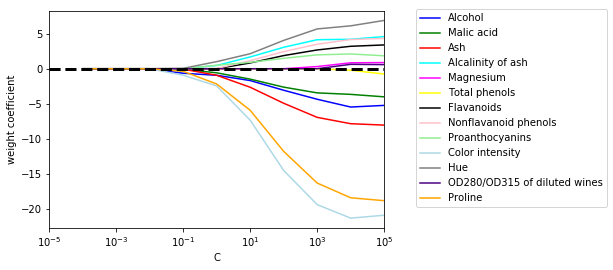

In [90]:
import matplotlib.pyplot as plt

fit = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.** c, solver='liblinear', multi_class='auto')
    lr.fit(X_train_std, y_train)
    # 取第二类的权重向量进行绘图
    weights.append(lr.coef_[1])
    params.append(10. ** c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             # 去除Classlabel列
             label=df_wine.columns[column + 1],
             color=color)

    # 在x轴方向0位置加入水平基准线
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

### b. 序列特征选择算法
另一种降低模型复杂度解决过拟合问题的方法是通过特征选择进行降维。降维技术主要分为两类：特征选择和特征提取。通过特征选择，可以选择出原始特征集的一个子集；特征提取是通过对现有特征信息进行推演，构造出一个新的特征子空间。

序列特征选择算法（Sequential Backward Selection SBS）：
1. 设$k=d$进行算法初始化，其中d是特征空间$X_d$的维度；
2. 定义$x^-$为满足标准$x^-=argmaxJ(X_k - x)$最大化的特征，其中$x\in{X_k}$;
3. 将特征$x^-$从特征集中删除：$X_{k-1}=X_k - x^-, k=k-1$;
4. 如果k等于目标特征数量，算法终止，否则跳回第2步。

In [100]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
# 使用accuracy_score作为衡量标准
from sklearn.metrics import accuracy_score
if Version(sklearn_v) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
class SBS():
    
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        # 评价特征的学习器
        self.estimator = clone(estimator)
        # 最终得到的特征子集的维度
        self.k_features = k_features
        # 测试集的大小
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        # 切分数据集
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        # dim为初始特征集合的大小
        dim = X_train.shape[1]
        # 建立dim个特征的索引
        self.indices_ = tuple(range(dim))
        # 初始特征子集（和原集合大小相同）
        self.subsets_ = [self.indices_]
        # 计算当前特征集在学习器上的得分
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        # 将当前得分加入得分总列表
        self.scores_ = [score]
        
        # 循环条件，特征子集的大小小于等于k停止
        while dim > self.k_features:
            scores = []
            subsets = []
            
            # combinations创建一个迭代器，返回indices_中长度为r的子序列
            # 返回的序列按照indices_原顺序排序，不带重复项
            # 这里对所有大小为dim-1的子集进行测试
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            # 取出得分最高的子集索引
            best = np.argmax(scores)
            # 获取得分最高的子集
            self.indices_ = subsets[best]
            # 加入到待优化序列执行下一次特征选择
            self.subsets_.append(self.indices_)
            dim -= 1
            
            # 把当前子集的得分加入到总得分列表
            self.scores_.append(scores[best])
        # 循环完成后，得到了k个特征，选取最后一个作为最后的得分
        # 因为最后一个加入的是最优的
        self.k_score_ = self.scores_[-1]
    
        return self
    
    def transform(self, X):
        # 取数据集的指定列
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # 训练学习器
        self.estimator.fit(X_train[:, indices], y_train)
        # 预测输出，并给出准确率
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

下面在KNN分类器中验证SBS算法的表现：

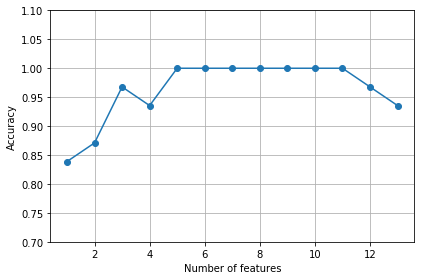

In [101]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# 特征选择
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

上面的SBS算法在每一步中都存储了最优特征子集的得分在scores_中，从上面可以看到，当特征数$k=\{5, 6, 7, 8, 9, 10\}$时，算法的正确率可以达到100%。下面我们看看究竟是哪5个特征具有如此好的表现。

In [103]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 12),
 (0, 1, 2, 3, 6, 7, 8, 10, 12),
 (0, 1, 2, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 10, 12),
 (0, 1, 3, 10, 12),
 (0, 1, 10, 12),
 (0, 1, 10),
 (0, 10),
 (0,)]

从上面可以很清楚的看到特征选择的过程，每次去除一个特征，不断缩减。

In [102]:
# 选择第8列看一看表现最好的5个特征
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


下面验证一下kNN分类器在原始测试集上的表现

In [109]:
knn.fit(X_train_std, y_train)
print("Training accuracy:", knn.score(X_train_std, y_train))

Training accuracy: 0.9838709677419355


In [110]:
print("Test accuracy:", knn.score(X_test_std, y_test))

Test accuracy: 0.9444444444444444


测试集的准确率比训练集稍低，说明有些过拟合。下面在选定的5个特征上进行训练再次观察：

In [116]:
knn.fit(X_train_std[:, k5], y_train)
print("Training accuracy:", knn.score(X_train_std[:, k5], y_train))

Training accuracy: 0.9596774193548387


In [117]:
print("Test accuracy:", knn.score(X_test_std[:, k5], y_test))

Test accuracy: 0.9629629629629629


可以发现，测试集的准确率高于训练集，说明过拟合现象得到了缓解。

## 6. 通过随机森林判定特征的重要性
我们可以通过森林中所有决策树得到的平均不纯度衰减来衡量特征的重要性，而不必考虑数据是否线性可分。在sklearn中可以通过feature_importances_得到这些内容。

 1)  Color intensity                0.182483
 2)  Proline                        0.158610
 3)  Flavanoids                     0.150948
 4)  OD280/OD315 of diluted wines   0.131987
 5)  Alcohol                        0.106589
 6)  Hue                            0.078243
 7)  Total phenols                  0.060718
 8)  Alcalinity of ash              0.032033
 9)  Malic acid                     0.025400
10)  Proanthocyanins                0.022351
11)  Magnesium                      0.022078
12)  Nonflavanoid phenols           0.014645
13)  Ash                            0.013916


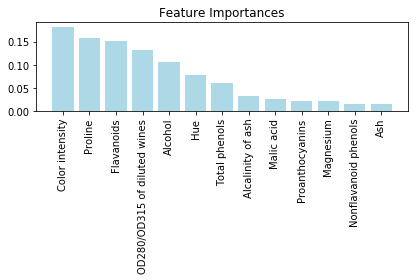

In [132]:
from sklearn.ensemble import RandomForestClassifier

# 获取所有特征
feat_labels = df_wine.columns[1:]
# 训练10000棵树
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
# 获取特征重要性列表
importances = forest.feature_importances_
# 对列表从大到小排序，返回索引
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d)  %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color='lightblue',
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()